[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores.El cual hicimos en conjunto todo el curso.

Una vez extraído el dataset, podemos ver que tenemos 7 clases de flores diferentes, distribuidas en 7 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
import os 

PATH = '/content/gdrive/MyDrive/IA2/TODOS/dataset_flores'

classes = os.listdir(PATH)
classes

['lirio', 'FlorRita', 'Girasoles', 'tagetes', 'Hibisco', 'claveles', 'rosas']

In [17]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: lirio. Imágenes: 1260
Categoría: FlorRita. Imágenes: 1186
Categoría: Girasoles. Imágenes: 742
Categoría: tagetes. Imágenes: 1453
Categoría: Hibisco. Imágenes: 1132
Categoría: claveles. Imágenes: 1001
Categoría: rosas. Imágenes: 1000


Podemos visualizar algunas imágenes en el dataset.

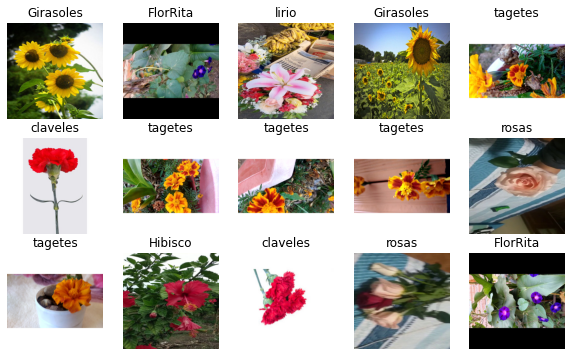

In [18]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [19]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(6219, 1555)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [20]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
      #reordenamos
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [21]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(6219, 1555)

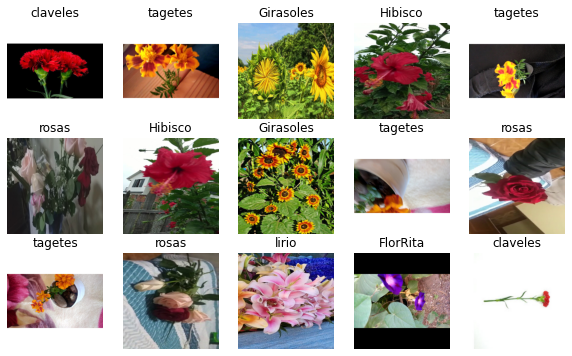

In [22]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [23]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [24]:
import torchvision

resnet = torchvision.models.resnet18()
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    #no se entrenen todas las capas
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 7)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [26]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 7])

In [27]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [29]:
model = Model()
fit(model, dataloader, epochs=5)

val_loss 0.64000 val_acc 0.78495: 100%|██████████| 7/7 [07:44<00:00, 66.42s/it]


Epoch 1/5 loss 0.68246 val_loss 0.64000 acc 0.85335 val_acc 0.78495


val_loss 0.13454 val_acc 0.98047: 100%|██████████| 7/7 [00:20<00:00,  2.91s/it]


Epoch 2/5 loss 0.13907 val_loss 0.13454 acc 0.97401 val_acc 0.98047


val_loss 0.06870 val_acc 0.99051: 100%|██████████| 7/7 [00:20<00:00,  2.89s/it]


Epoch 3/5 loss 0.07816 val_loss 0.06870 acc 0.98517 val_acc 0.99051


val_loss 1.42057 val_acc 0.63989: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


Epoch 4/5 loss 0.06195 val_loss 1.42057 acc 0.98711 val_acc 0.63989


val_loss 3.80510 val_acc 0.51771: 100%|██████████| 7/7 [00:20<00:00,  2.93s/it]

Epoch 5/5 loss 0.04407 val_loss 3.80510 acc 0.99046 val_acc 0.51771


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [30]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 0.20717 val_acc 0.98605: 100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


Epoch 1/5 loss 0.64338 val_loss 0.20717 acc 0.88728 val_acc 0.98605


val_loss 0.11074 val_acc 0.98940: 100%|██████████| 7/7 [00:20<00:00,  2.97s/it]


Epoch 2/5 loss 0.16875 val_loss 0.11074 acc 0.99043 val_acc 0.98940


val_loss 0.07995 val_acc 0.99163: 100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


Epoch 3/5 loss 0.10850 val_loss 0.07995 acc 0.99283 val_acc 0.99163


val_loss 0.05997 val_acc 0.99386: 100%|██████████| 7/7 [00:20<00:00,  2.91s/it]


Epoch 4/5 loss 0.07900 val_loss 0.05997 acc 0.99410 val_acc 0.99386


val_loss 0.04924 val_acc 0.99498: 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]

Epoch 5/5 loss 0.06398 val_loss 0.04924 acc 0.99522 val_acc 0.99498


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [31]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)

val_loss 0.03635 val_acc 0.99721: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]


Epoch 1/5 loss 0.27723 val_loss 0.03635 acc 0.95647 val_acc 0.99721


val_loss 0.01526 val_acc 0.99888: 100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


Epoch 2/5 loss 0.03032 val_loss 0.01526 acc 0.99793 val_acc 0.99888


val_loss 0.01020 val_acc 0.99944: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 3/5 loss 0.01594 val_loss 0.01020 acc 0.99888 val_acc 0.99944


val_loss 0.00770 val_acc 0.99944: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 4/5 loss 0.01063 val_loss 0.00770 acc 0.99968 val_acc 0.99944


val_loss 0.00612 val_acc 0.99944: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]

Epoch 5/5 loss 0.00778 val_loss 0.00612 acc 1.00000 val_acc 0.99944


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [32]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)

val_loss 0.22923 val_acc 0.98772: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 1/5 loss 0.64661 val_loss 0.22923 acc 0.88233 val_acc 0.98772


val_loss 0.11180 val_acc 0.99498: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 2/5 loss 0.17172 val_loss 0.11180 acc 0.98932 val_acc 0.99498


val_loss 0.08003 val_acc 0.99442: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 3/5 loss 0.10994 val_loss 0.08003 acc 0.99078 val_acc 0.99442


val_loss 0.06120 val_acc 0.99554: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 4/5 loss 0.08090 val_loss 0.06120 acc 0.99238 val_acc 0.99554


val_loss 0.04979 val_acc 0.99721: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 5/5 loss 0.06464 val_loss 0.04979 acc 0.99490 val_acc 0.99721


val_loss 0.04735 val_acc 0.99721: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 1/5 loss 0.05914 val_loss 0.04735 acc 0.99665 val_acc 0.99721


val_loss 0.04566 val_acc 0.99721: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


Epoch 2/5 loss 0.05649 val_loss 0.04566 acc 0.99665 val_acc 0.99721


val_loss 0.04451 val_acc 0.99777: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 3/5 loss 0.05294 val_loss 0.04451 acc 0.99681 val_acc 0.99777


val_loss 0.04211 val_acc 0.99721: 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]


Epoch 4/5 loss 0.05204 val_loss 0.04211 acc 0.99681 val_acc 0.99721


val_loss 0.04171 val_acc 0.99777: 100%|██████████| 7/7 [00:19<00:00,  2.78s/it]

Epoch 5/5 loss 0.05228 val_loss 0.04171 acc 0.99601 val_acc 0.99777


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [33]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.